In [1]:
import pennylane as qml
import pennylane.numpy as np
from sklearn import datasets
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from pennylane.operation import Operation, AnyWires

In [182]:
from pennylane.operation import Operation, AnyWires

class Rig_RyTh1(Operation):
    num_wires = 1  

    def __init__(self, theta, wires, id=None):
        all_wires = qml.wires.Wires(wires)
        super().__init__(theta, wires=all_wires, id=id)

    @staticmethod
    def compute_decomposition(theta, wires):
        decomp = [
                qml.RX(np.pi/2.,wires=wires[0]),
                qml.RZ(-theta,wires=wires[0]),
                qml.RX(-np.pi/2.,wires=wires[0]),
            ]
        return decomp
    
class Rig_RzTh1(Operation):
    num_wires = 1  

    def __init__(self, theta, wires, id=None):
        all_wires = qml.wires.Wires(wires)
        super().__init__(theta, wires=all_wires, id=id)

    @staticmethod
    def compute_decomposition(theta, wires):
        decomp = [
                qml.RZ(theta,wires=wires[0]),
            ]
        return decomp
    
class Rig_RyzTh1(Operation):
    num_wires = 1  

    def __init__(self, thetas, wires, id=None):
        all_wires = qml.wires.Wires(wires)
        super().__init__(thetas, wires=all_wires, id=id)

    @staticmethod
    def compute_decomposition(theta, wires):
        decomp = [
                qml.RX(np.pi/2.,wires=wires[0]),
                qml.RZ(-thetas[0],wires=wires[0]),
                qml.RX(-np.pi/2.,wires=wires[0]),
                qml.RZ(thetas[1],wires=wires[0]),
            ]
        return decomp
    
#class Rig_iSWAP(Operation):
#    num_wires = 2  
#
#    def __init__(self, theta, wires, id=None):
#        all_wires = qml.wires.Wires(wires)
#        super().__init__(theta, wires=all_wires, id=id)
#
#    @staticmethod
#    def compute_decomposition(theta, wires):
#        decomp = [
#                qml.RX(np.pi/2.,wires=wires[0]),
#                qml.RZ(-theta,wires=wires[0]),
#                qml.RX(-np.pi/2.,wires=wires[0]),
#            ]
#        return decomp
    
class Rig_CZ(Operation):
    num_wires = 2  

    def __init__(self, wires, id=None):
        all_wires = qml.wires.Wires(wires)
        super().__init__(wires=all_wires, id=id)

    @staticmethod
    def compute_decomposition(wires):
        decomp = [
                qml.CZ(wires=wires),
            ]
        return decomp

In [214]:
import pennylane.numpy as np


n_qubits=9
n_features=13
dev = qml.device("default.qubit", wires=n_qubits)

s=0.05
init_method=lambda x: torch.nn.init.uniform_(x,a=0.,b=s*np.pi)

Conn_map=[
    [[4,1],[3,0],[5,2],[7,8]],
    [[4,3],[1,0],[7,6],[5,8]],
    [[4,7],[3,6],[1,0],[5,2]],
    [[4,5],[7,8],[1,2],[3,0]],
]
excl_qbts=[[6,], [2,], [8,], [6,]]

n_layers=2

n_pars=n_layers*18*5 #+4*3+3
@qml.qnode(dev)
def probs_single_custom(inputs, weights):
   
#    for fi in range(0, n_features):
#        qi=fi%n_qubits
#        gat=Rig_RyTh1 if fi<n_qubits else Rig_RzTh1
#        gat(inputs[...,fi],wires=qi,id=f"$\\alpha_{{{{{fi}}}}}$")
    
    
    theta_i=0
    for lay_i in range(n_layers): 
        # input injection
        for fi in range(0, n_features):
            qi=fi%n_qubits
            gat=Rig_RyTh1 if fi<n_qubits else Rig_RzTh1
            ft_idx=fi if lay_i%2==0 else n_features-fi-1
            gat(inputs[...,ft_idx],wires=qi,id=f"$\\alpha_{{{{{fi}}}}}$")
            
        # parameterized circuit injection
        for nn_i, nn_conn in enumerate(Conn_map): 
            for qi_qj in nn_conn:
                Rig_CZ(wires=qi_qj)
            for qi in range(n_qubits):
                if qi in excl_qbts[nn_i]:
                    continue
                Rig_RyTh1(weights[lay_i][theta_i],wires=qi,id=f"$\\theta_{{{{{lay_i,theta_i}}}}}$")
                Rig_RzTh1(weights[lay_i][theta_i+1],wires=qi,id=f"$\\theta_{{{{{lay_i,theta_i+1}}}}}$")
                theta_i+=2
        
    return qml.probs(wires=range(0,9))
    
weight_shapes = {"weights": (n_layers, n_pars)}
qlayer = qml.qnn.TorchLayer(probs_single_custom, weight_shapes,init_method=init_method)

/home/joe/.local/lib/python3.10/site-packages/pennylane/math/utils.py:227: UserWarning: Contains tensors of types {'torch', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


(<Figure size 2952x720 with 1 Axes>, <Axes:>)

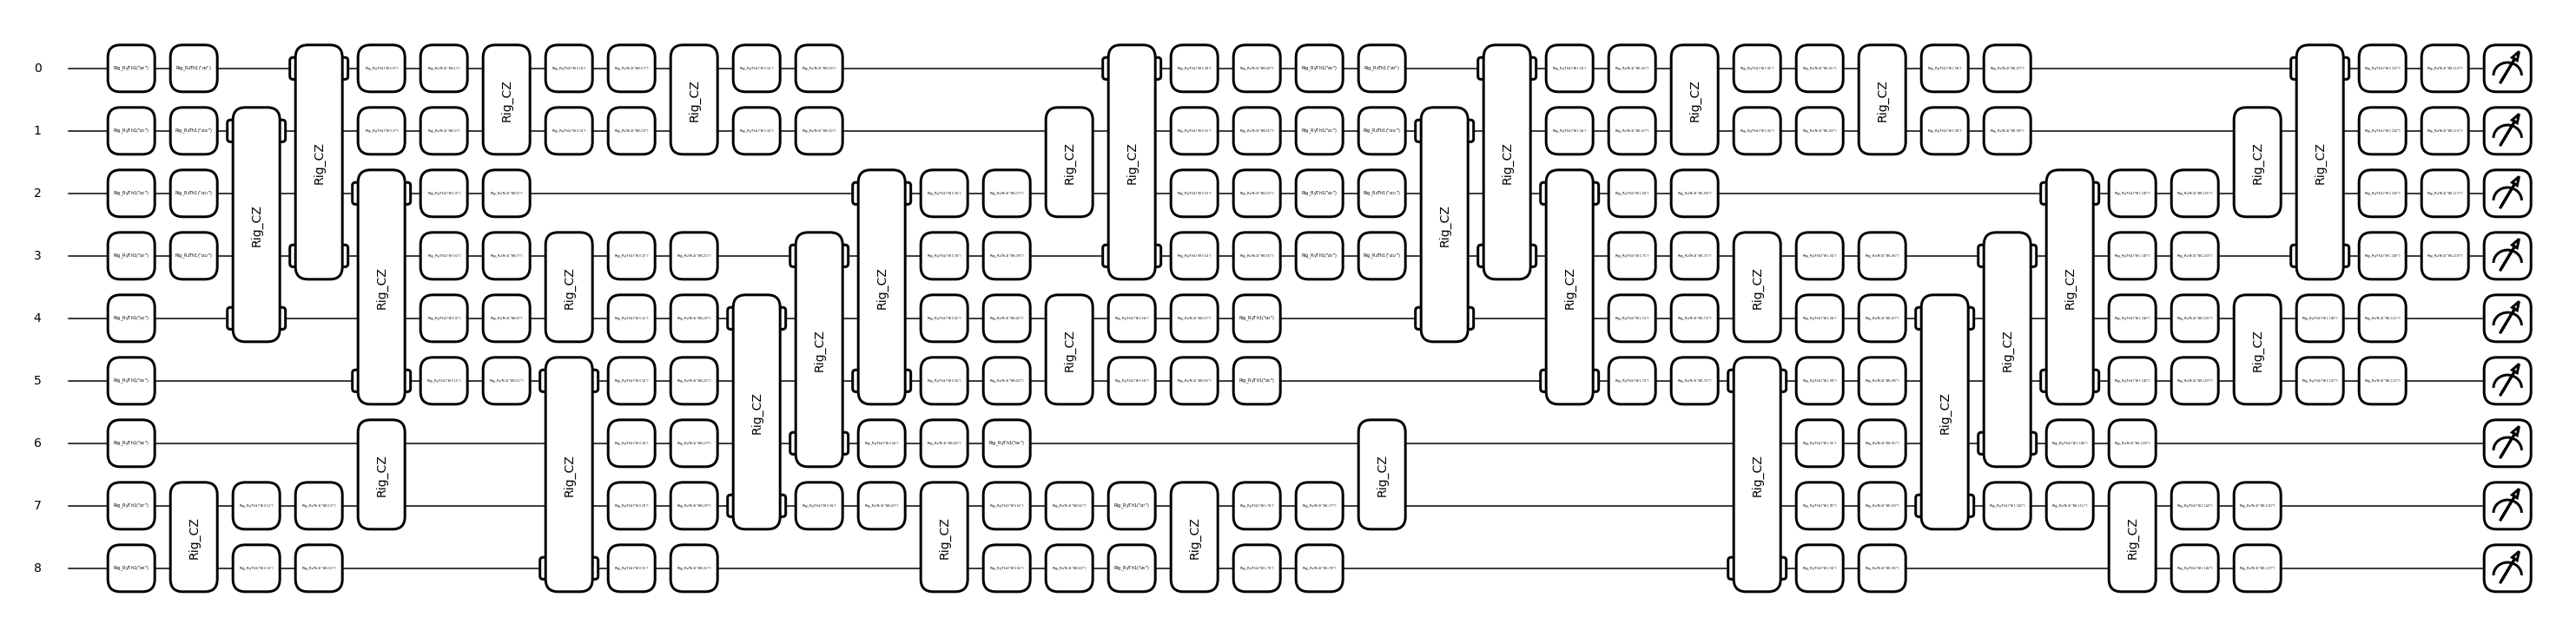

In [215]:
%matplotlib inline
qml.draw_mpl(probs_single_custom)(torch.rand(13),np.random.random(weight_shapes['weights']))

In [216]:
#mp_f=lambda i,b: (0.5*(1+(-1)**((i//(2**b))%2)))
mp_f=lambda i,b: (-1)**((i//(2**b))%2)
import torch.nn as nn
class ProbsToclassLayer(nn.Module):
    def __init__(self, size_in):
        super(ProbsToclassLayer, self).__init__()
        self.size_q_in=size_in

    def forward(self, input_var):
        Mat=torch.tensor([[2.0*(mp_f(i,j)+mp_f(i,j+1)+mp_f(i,j+2)) for j in range(0,9,3)] for i in range(input_var.shape[1])],requires_grad=False)
        return input_var@Mat

In [217]:
wine = datasets.load_wine()
#print(wine.data.shape,  len(np.unique(wine.target)) )

n_features=wine.data.shape[1]
xy_labels=[(wine.data[idx,:],wine.target[idx]) for idx in range(len(wine.data))]
feature_list=[[x_lab[ft_i] for x_lab,y_lab in xy_labels] for ft_i in range(n_features)]

#standardize features
mean_std_list=[[np.mean(feature_list[ft_i]),np.std(feature_list[ft_i])] for ft_i in range(n_features)]
xy_labels_stdd=[([(el[0][ft_i]-mean_std_list[ft_i][0])/mean_std_list[ft_i][1] for ft_i in range(n_features)],el[1]) for ei,el in enumerate(xy_labels)]
#norms_list=[np.sqrt(np.sum([val**2 for val in el[0]])) for el in xy_labels_stdd]
#xy_labels_stdd=[([val/norms_list[ei] for val in el[0]],el[1]) for ei,el in enumerate(xy_labels_stdd)]
xy_labels=xy_labels_stdd
#xy_labels

X=np.array([x for x,y in xy_labels_stdd])
y_=np.array([y for x,y in xy_labels_stdd])
#y = torch.unsqueeze(torch.tensor(y,requires_grad=False), 1)
#y_hot = torch.scatter(torch.zeros((200, 2),requires_grad=False), 1, y_, 1)
X = torch.tensor(X, requires_grad=False).float()
y = torch.tensor(y_, requires_grad=False).long()

In [218]:
import matplotlib.pyplot as plt
def test_plot_model(y_pred):
    pbs_arr=[]
    for xii, (x_lab, y_lab) in enumerate(zip(X,y)):
        pbs=y_pred[xii].detach().numpy()
        pbs_arr.append(pbs[:])
        idx_max=np.argmax(pbs[:])
    #    y_lab_pred="0" if idx_max==1 else "1"
#        print(int(y_lab), " ", idx_max, " ", pbs)
    pbs_arr=np.array(pbs_arr)
    colors=['g','b','r']
    color_points=[colors[yv] for yv in y]
    fig,ax=plt.subplots()
    ax.scatter(pbs_arr[:,1],pbs_arr[:,2],c=color_points,alpha=0.5,s=5)
    plt.show()

In [219]:
import pennylane.numpy as np
#clayer1=nn.Linear(8,8)
#softmax1=nn.Softmax(dim=1)
#sigmoid1=nn.Sigmoid()
#clayer2=nn.Linear(16,3)
#torch.nn.init.uniform_(clayer2.weight,b=0.1) 
softmax=nn.Softmax(dim=1)
probs2class=ProbsToclassLayer(2**9)
#layers = [qlayer1,qlayer2,clayer2,softmax2]
layers = [qlayer,probs2class,softmax]
model = torch.nn.Sequential(*layers)
#model.apply(init_method)

#opt = torch.optim.SGD(model.parameters(), lr=0.1)
opt = torch.optim.Adam(model.parameters(),lr=0.1)
#opt = torch.optim.Adam(model.parameters(),lr=0.05)
#loss = torch.nn.MSELoss()

loss = torch.nn.CrossEntropyLoss()
for pr in model.parameters():
    print(pr)

Parameter containing:
tensor([[0.0856, 0.1007, 0.1384, 0.0478, 0.0614, 0.1404, 0.1152, 0.0518, 0.0622,
         0.0606, 0.0165, 0.0882, 0.0412, 0.1094, 0.0843, 0.1396, 0.0833, 0.0767,
         0.0106, 0.1395, 0.0952, 0.0469, 0.0930, 0.0254, 0.1060, 0.0192, 0.0313,
         0.0064, 0.0970, 0.1012, 0.0414, 0.1456, 0.0935, 0.0819, 0.0475, 0.0821,
         0.1463, 0.1016, 0.0407, 0.1175, 0.1238, 0.0930, 0.0187, 0.0295, 0.0911,
         0.0175, 0.0939, 0.0609, 0.1163, 0.1539, 0.1434, 0.0228, 0.0794, 0.1318,
         0.1485, 0.0024, 0.0016, 0.0627, 0.0100, 0.1411, 0.0332, 0.0045, 0.1094,
         0.1067, 0.0437, 0.1387, 0.0692, 0.1297, 0.0621, 0.0953, 0.0833, 0.0602,
         0.0628, 0.1139, 0.0444, 0.0238, 0.1115, 0.1049, 0.0835, 0.0092, 0.1533,
         0.0004, 0.0069, 0.1184, 0.1111, 0.0955, 0.0147, 0.0403, 0.0694, 0.1076,
         0.0886, 0.0325, 0.1439, 0.0099, 0.1555, 0.1462, 0.1022, 0.1445, 0.0383,
         0.1374, 0.0433, 0.1232, 0.0320, 0.1384, 0.0919, 0.0181, 0.1290, 0.0938,
      

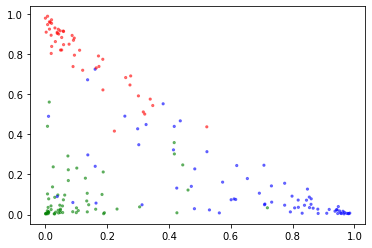

Average loss over epoch 1: 0.7237


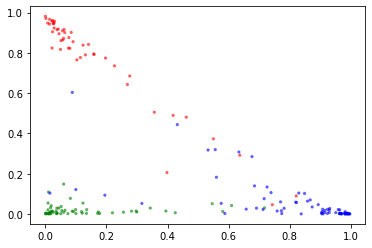

Average loss over epoch 2: 0.6277


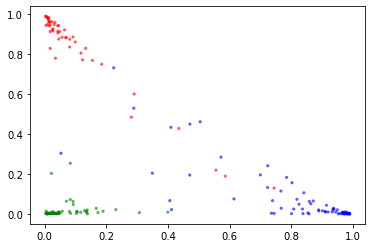

Average loss over epoch 3: 0.5999


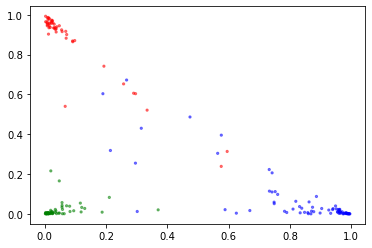

Average loss over epoch 4: 0.5658


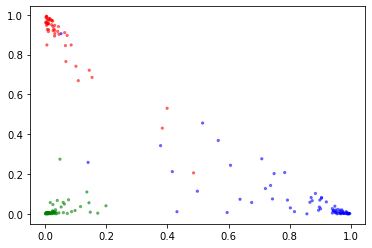

Average loss over epoch 5: 0.5562


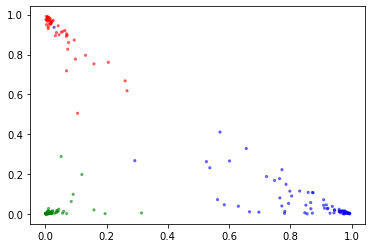

Average loss over epoch 6: 0.5465


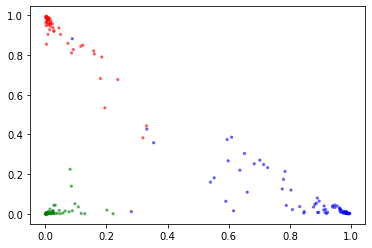

Average loss over epoch 7: 0.5481


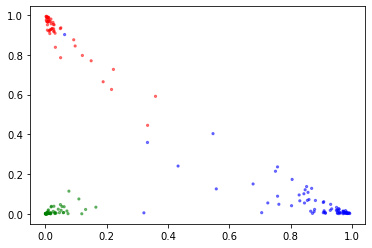

Average loss over epoch 8: 0.5361


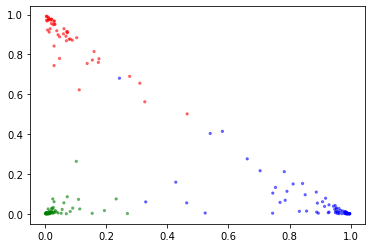

Average loss over epoch 9: 0.5372


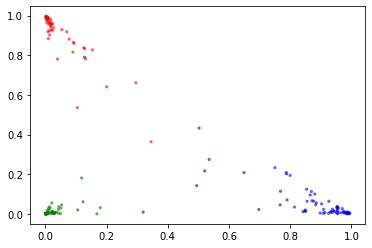

Average loss over epoch 10: 0.5416


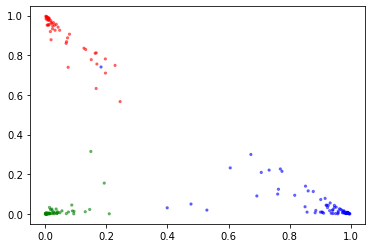

Average loss over epoch 11: 0.5345


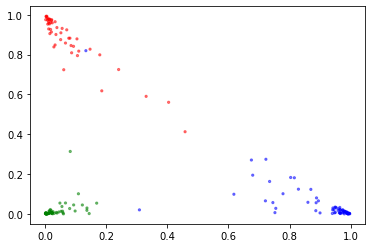

Average loss over epoch 12: 0.5347


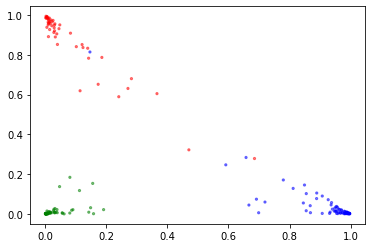

Average loss over epoch 13: 0.5303


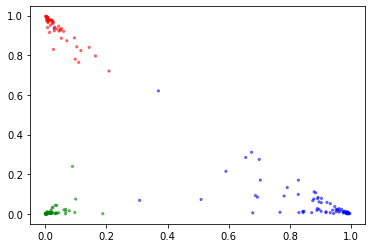

Average loss over epoch 14: 0.5297


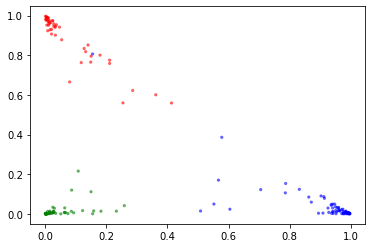

Average loss over epoch 15: 0.5232


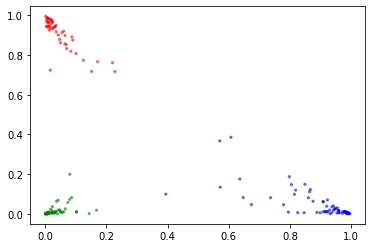

Average loss over epoch 16: 0.5277


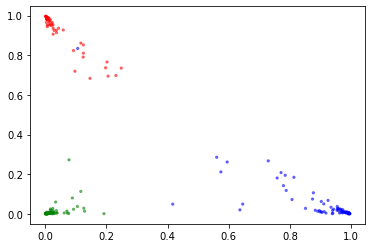

Average loss over epoch 17: 0.5282


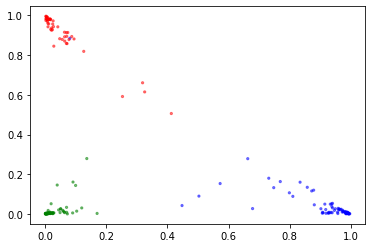

Average loss over epoch 18: 0.5292


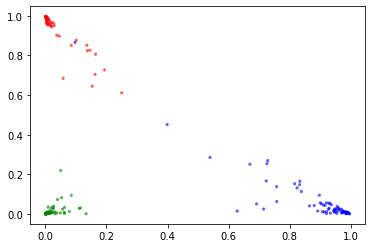

Average loss over epoch 19: 0.5238


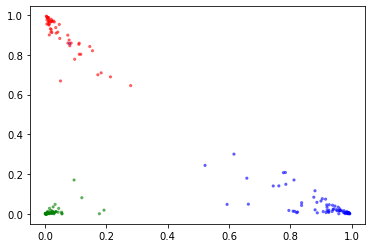

Average loss over epoch 20: 0.5271


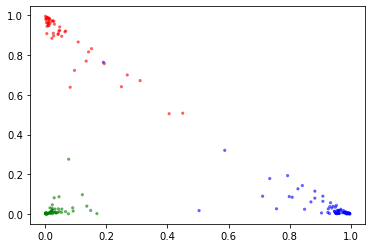

Average loss over epoch 21: 0.5284


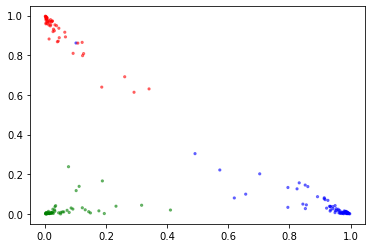

Average loss over epoch 22: 0.5330


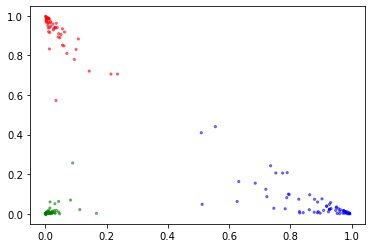

Average loss over epoch 23: 0.5238


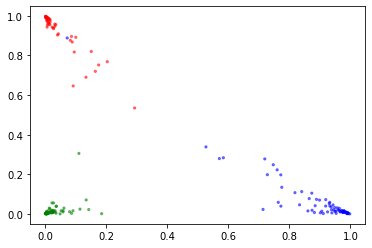

Average loss over epoch 24: 0.5345


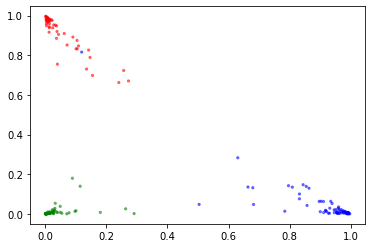

Average loss over epoch 25: 0.5197


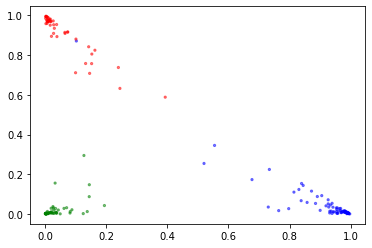

Average loss over epoch 26: 0.5297


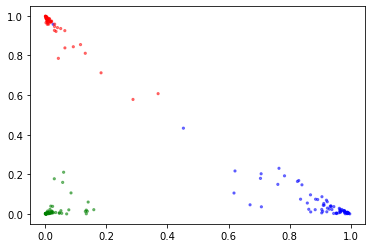

Average loss over epoch 27: 0.5187


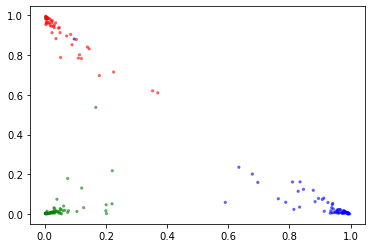

Average loss over epoch 28: 0.5247


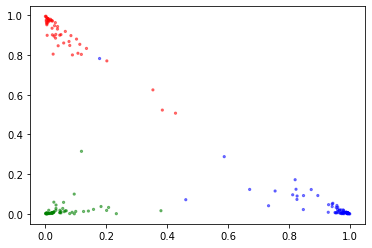

Average loss over epoch 29: 0.5272


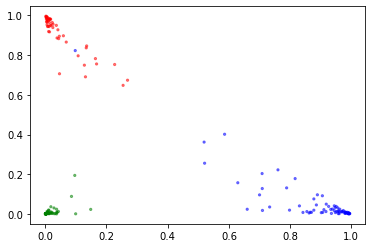

Average loss over epoch 30: 0.5224
Accuracy: 99.43820224719101%


In [220]:
#%pylab inline

#y = y_hot.float()
#y_hot = y_hot.float()

batch_size = 10
batches = 200 // batch_size

data_loader = torch.utils.data.DataLoader(
    list(zip(X, y)), batch_size=batch_size, shuffle=True, drop_last=True
)
epochs = 30

loss_list=[]
for epoch in range(epochs):

    running_loss = 0

    for xs, ys in data_loader:
        opt.zero_grad()

        loss_evaluated = loss(model(xs), ys)
        loss_evaluated.backward()
#        print(xs, model(xs),ys,loss_evaluated)
        loss_list.append(loss_evaluated.detach().numpy())

        opt.step()

        running_loss += loss_evaluated
    y_pred = model(X)
    test_plot_model(y_pred)

    avg_loss = running_loss / batches
    print("Average loss over epoch {}: {:.4f}".format(epoch + 1, avg_loss))

predictions = torch.argmax(y_pred, axis=1).detach().numpy()

correct = [1 if p == p_true else 0 for p, p_true in zip(predictions, y)]
accuracy = sum(correct) / len(correct)
print(f"Accuracy: {accuracy * 100}%")

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['np']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


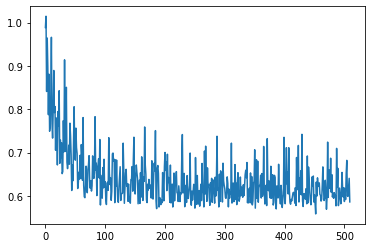

In [221]:
%pylab inline
plot(loss_list)

In [224]:
pbs_arr=[]
for xii, (x_lab, y_lab) in enumerate(zip(X,y)):
    pbs=y_pred[xii].detach().numpy()
    pbs_arr.append(pbs[:])
    idx_max=np.argmax(pbs[:])
#    y_lab_pred="0" if idx_max==1 else "1"
    print(int(y_lab), " ", idx_max, " ", pbs)
pbs_arr=np.array(pbs_arr)

0   0   [0.97099864 0.02413251 0.00486889]
0   0   [0.9390928  0.03694998 0.02395722]
0   0   [0.97501695 0.02238107 0.00260195]
0   0   [0.9452231  0.01836723 0.0364098 ]
0   0   [0.9814902  0.00573198 0.01277785]
0   0   [9.9838614e-01 1.3166969e-03 2.9717886e-04]
0   0   [0.9949995  0.00328669 0.00171378]
0   0   [0.9887067  0.00929829 0.00199499]
0   0   [9.9701774e-01 2.3815732e-03 6.0072663e-04]
0   0   [0.97034353 0.02041584 0.00924061]
0   0   [0.995667   0.00310351 0.00122953]
0   0   [0.9940154  0.00409704 0.00188762]
0   0   [0.98736435 0.01037352 0.00226217]
0   0   [8.999706e-01 9.928364e-02 7.457710e-04]
0   0   [9.6270788e-01 3.6911633e-02 3.8045322e-04]
0   0   [9.9699843e-01 2.4541600e-03 5.4746156e-04]
0   0   [0.9940454  0.00406584 0.00188875]
0   0   [9.9713099e-01 2.2292167e-03 6.3976180e-04]
0   0   [9.9812251e-01 1.4893278e-03 3.8811995e-04]
0   0   [0.97271675 0.01713794 0.01014528]
0   0   [0.9842763  0.01309691 0.00262674]
0   0   [0.9827344  0.00789591 0.0093

Populating the interactive namespace from numpy and matplotlib


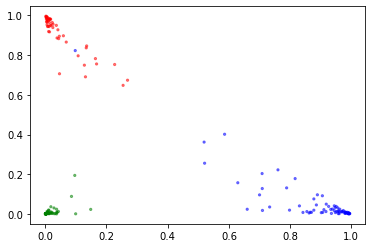

In [225]:
%pylab inline
colors=['g','b','r']
color_points=[colors[yv] for yv in y]
scatter(pbs_arr[:,1],pbs_arr[:,2],c=color_points,alpha=0.5,s=5)

In [226]:
print(f"Accuracy: {accuracy * 100}%")

Accuracy: 99.43820224719101%
